# Import

In [1]:
import time as time
import numpy as np
import pandas as pd
import csv
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import seaborn as sns
import scipy.io
import scipy.stats
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
import sys
sys.path.insert(1, '/Users/felicia/Documents/CFIN/ensembles_code') # change path here!
import assembly as assembly

# Load airpuff data

In [ ]:
"""
Load activity matrix data as [n_cells, n_timepoints]

Run patterns:
    -Marcenko-Pastur distribution
    -input: actmat (activity matrix)
    -output:
        -patterns (assemblies) as [assemblies, neurons]
        -significance (general information about significance tests)
        -zactmat (z-scored activity matrix)
        
Compute assembly activity
    -using patterns and zactmat

The preprocessed data gets loaded as an activity matrix, with the activity of each cell across time. The runPattern
function is run on the matrix, using the cell activity matrix as input (actmat). This script uses the 
Marcenko-Pastur distribution. The function then outputs the patterns (aka assemblies), which gives a probability 
for the membership of each cell to each assembly. The function also outputs some general information about 
significance tests and the z-scored activity matrix (zactmat). Both the zactmat and patterns matrices are used as 
input to compute the assembly activity matrix, which gives the activity of each assembly across time. 

---------
This code is based on:
    Lopes-dos-Santos, V., Ribeiro, S., & Tort, A. B. L. (2013). Detecting cell assemblies in large neuronal 
    populations. Journal of Neuroscience Methods, 220(2), 149–166. https://doi.org/10.1016/j.jneumeth.2013.04.010
    
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -sys, random, copy, csv, os, time, pickle
"""

In [2]:
#### change folder path here for each animal!
animal_folder_name = "/Users/felicia/Documents/CFIN/233/233_traces"

#### change session number here
session = 17

In [3]:
# SPIKING DATA
#animal_folder_name = "/Users/felicia/Documents/CFIN/16.1/Superchris"
#bhv_info_filename = "SuperChris-2-12-09_MS_EnsembleMatrix.mat"

#import h5py
#f = h5py.File(os.path.join(animal_folder_name, bhv_info_filename),'r')
#trial_info = f.get('ensembleMatrix')
#trial_info = np.array(trial_info) # For converting to a NumPy array
#### no preprocessing - skip to MP distribution

In [4]:
# LOAD CSV CALCIUM TRACES
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape

# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

#create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()
    
# LOAD BEHAVIOURAL DATA
#folder_name = "trial_info"
#bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
#trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

# extract information from trial_info: in matlab this is a struct with the fields:
#trials_start_time = trial_info['trial_info'][0,0][0].ravel()
#trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
#trials_response = trial_info['trial_info'][0,0][2].ravel()
#trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
#trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
#trials_end_time = trial_info['trial_info'][0,0][5].ravel()
#n_trials = len(trials_end_time) # number of trials

# load behavioural data (.pkl file)
input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     trial_info = pickle.load(fp)

# extract information for trial_info: in PYTHON
trials_start_time = np.array(trial_info['start_time'])
trials_stimulus_on = np.array(trial_info['stimulus_on'])
trials_response = np.array(trial_info['response'])
trials_is_right_lick = np.array(trial_info['is_right_lick'])
trials_is_reward = np.array(trial_info['is_reward'])
trials_end_time = np.array(trial_info['end_trial'])
n_trials = len(trials_end_time)

# 500msec between start and stimulus onset
new_start = [] # initiate empty list
new_end = [] # initiate empty list
new_start.append(trials_stimulus_on[0]-0.5) # append first start
new_end.append(trials_stimulus_on[1]-0.5) # append first end
for i in range(1,n_trials-1): # append start & end times for each trial (except last)
    new_start.append(trials_stimulus_on[i]-0.5)
    new_end.append(trials_stimulus_on[i+1]-0.5)
new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
new_end.append(trials_end_time[n_trials-1]) # append last end
new_start = np.array(new_start) # turn list to array
new_end = np.array(new_end)
n_trials = len(new_end)

# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

# Marcenko-Pastur function as null distribution

In [5]:
# MP distribution
actmat = np.transpose(channels_array) # [n_cells, n_timepoints] - spiking data doesn't need to be transposed!
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

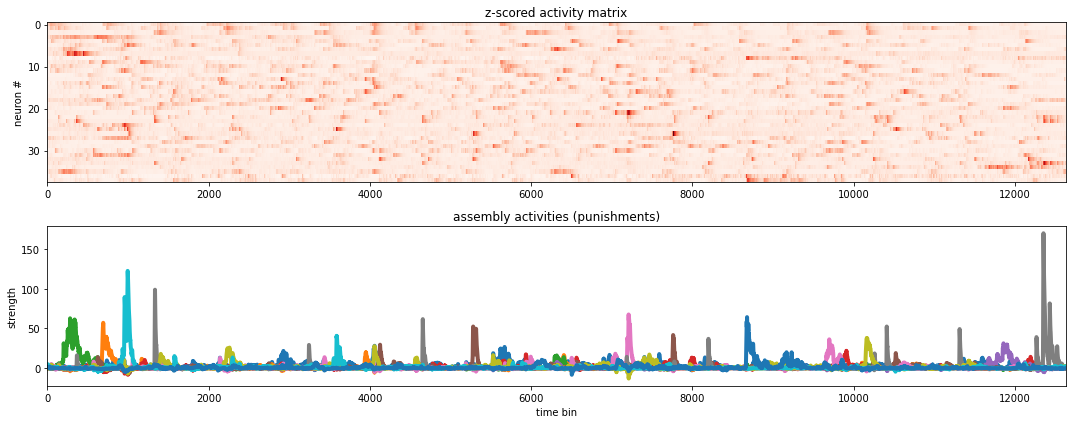

In [6]:
# plot ALL TRIALS: z-scored activity matrix
plt.figure(figsize=(15,6))
s1 = plt.subplot(211)
plt.imshow(zactmat,cmap='Reds',interpolation='nearest',aspect='auto')
plt.title('z-scored activity matrix')
plt.ylabel('neuron #')

# plot assemblies activities
plt.subplot(212,sharex=s1)
plt.plot(assemblyAct.T,linewidth=4)
plt.title('assembly activities (punishments)')
plt.xlabel('time bin')
plt.ylabel('strength')
plt.tight_layout()

# Note that the peaks of assembly activity correspond to co-activations of the corresponding assembly members

# split by trial

In [7]:
actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

# split by trial
# [n_trials, n_assemblies, n_timepoints]
X = {}
for i in range(n_trials-1):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = assemblyAct.T[lower_bound:upper_bound]
    
# number of assemblies
n_assemblies = assemblyAct.T.shape[1]
print("number of assemblies:",n_assemblies)

number of assemblies: 11


In [8]:
# normalize correlation data, bringing the firing of single units on the same scale
#z_units = scipy.stats.zscore(assemblyAct.T)
#X_norm = {}
#for i in range(n_trials):
#    lower_bound = np.min(np.where(time_array>=new_start[i]))
#    upper_bound = np.max(np.where(time_array<=new_end[i]))
#    X_norm[i] = z_units[lower_bound:upper_bound]

# Analysis on reward and punishment (aligned at response) - using assemblies

In [9]:
# create the data array you will need to use as X with shape [n_trials, n_assemblies, n_timepoints]
# align trials at the response
thr = 0.5 # set threshold for minimum time points before response
n_before_resp = 5 # number of timepoints before response
n_after_resp = 15 # number of timepoints after response
n_timepoints = n_before_resp+ n_after_resp # total number of timepoints in time window

selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1 # where enough timepoints
n_trials = np.sum(selected_trials) # number of trials
X_response = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))
j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
        if X[i].shape[0]-resp_timepoint>n_after_resp: # if not enough timepoints after response
            X_response[j,:,:] = x
            j +=1
                
# transpose to have X in shape [n_trials, n_assemblies, n_timepoints]
X_response = X_response.transpose(0,2,1)

In [10]:
# analysis on reward and punishment, aligned at response
decode_str = 'reward_or_punish'
b = trials_is_reward[0:-1]
y = b[selected_trials==1]

# ANALYSIS ALL 
print("assemblies decoding - response aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=3
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):
    xt = X_response[:,:,t] # decode from all correlations
    
    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1 

assemblies decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.648854961832061


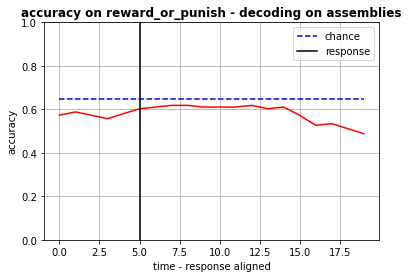

In [11]:
# plot reward or punishment at response
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp, color='k', label="response")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis stimulus (aligned at stimulus onset)

In [12]:
# create other X, this time 
# align at stimulus onset and decode where the stimulus was
# select the amount of points available in all trials around the stimulus

stim_to_end_min = 34 #int(np.min(new_end - trials_stimulus_on) / sampling_rate)
start_to_stim_min = 5 #int(np.min(trials_stimulus_on - new_start) / sampling_rate)

selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) * 10 > 35
n_trials = np.sum(selected_trials)

n_timepoints = start_to_stim_min + stim_to_end_min
#n_trials = len(new_end)
X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))

j=0
for i in range(len(new_start)-1):
    if selected_trials[i]==1:
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
        X_stimulus[j,:,:] = X[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
        j +=1
    
#transpose to have them in the right shape
X_stimulus = X_stimulus.transpose(0,2,1)

In [13]:
# analysis stimulus left or right with data aligned at stimulus onset
decode_str = 'stimulus_left_or_right'
y = stimulus_reconstruction[np.where(selected_trials)]

# ANALYSIS ALL 
print("assemblies decoding - stimulus aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)

# use only last kernel
n_splits=5
all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


for t in range(n_timepoints):    
    xt = X_stimulus[:,:,t]

    #stratified kfold to ensure every split has balanced amount of class
    outer_skf = StratifiedKFold(n_splits=n_splits)
    s=0
    for train_index, test_index in outer_skf.split(xt,y):
        x_train, x_test = xt[train_index], xt[test_index]
        y_train, y_test = y[train_index], y[test_index]  

        #should be a grid search for tuning the parameter
        model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
        s +=1           

assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.6372549019607843


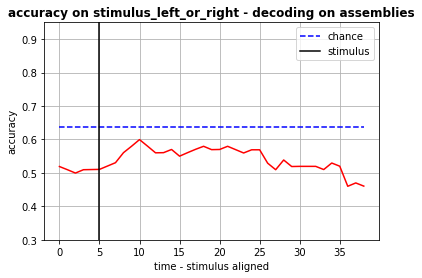

In [14]:
# plot stimulus decoding
fig = plt.figure()
plt.plot(np.arange(n_timepoints), np.mean(all_units_accuracy_diag, axis=1),'r')
plt.plot(np.arange(n_timepoints), np.ones(shape=(n_timepoints,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=start_to_stim_min, color='k', label="stimulus")
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

# Analysis reward/punishment after response across sessions

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4666666666666667


/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in rec

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5263157894736842
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.625
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.648854961832061
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.7945205479452054
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.8773006134969326


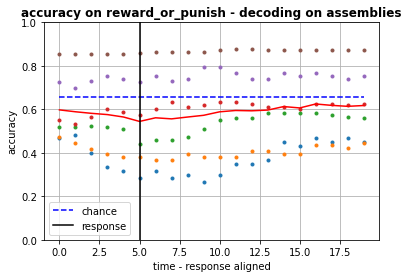

In [15]:
# set threshold for minimum time points after response
thr = 0.5
n_before_resp = 5
n_after_resp = 15
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):
    
    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
    
    # MP distribution
    actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
    patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

    # split traces data by trial
    # [n_trials, n_assemblies, n_timepoints]
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = assemblyAct.T[lower_bound:upper_bound]

    # number of assemblies
    n_assemblies = assemblyAct.T.shape[1]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1 # where enough timepoints
    n_trials = np.sum(selected_trials) # number of trials
    X_response = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X[i].shape[0]-resp_timepoint>n_after_resp: # if not enough timepoints after response
                X_response[j,:,:] = x
                j +=1
                
    # transpose to have X in shape [n_trials, n_assemblies, n_timepoints]
    X_response = X_response.transpose(0,2,1)
 
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)
    
    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # decode from all correlations
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
         
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.')

# plot accuracy & chance level
plt.plot(x, y1,'r') # mean accuracy
plt.plot(x, y2, '--b', label="chance") # mean chance level

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response") # response timepoint
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [16]:
# saving as pickle file
output_filename = "assemblies_activity/response_airpuff_assemblies.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(all_units_accuracy_diag_sessions, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis on stimulus onset across sessions

assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.55


/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in rec

assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5147058823529411
assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5238095238095238
assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.5267857142857143
assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.49122807017543857
assemblies decoding - stimulus aligned - stimulus_left_or_right
stimulus_left_or_right class balance: 
0.4928571428571429


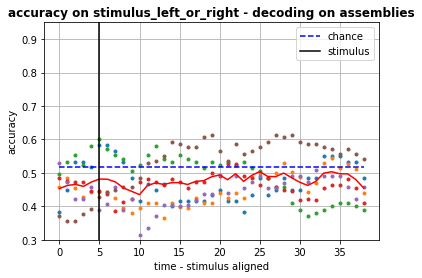

In [17]:
# set threshold for minimum time points before response
n_before_resp = 24
n_after_resp = 5

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
        
    # MP distribution
    actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
    patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

    # split traces data by trial
    # [n_trials, n_assemblies, n_timepoints]
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = assemblyAct.T[lower_bound:upper_bound]

    # number of assemblies
    n_assemblies = assemblyAct.T.shape[1]
        
    #### DECODING ####
    selected_trials = (new_end[0:-1] - trials_stimulus_on[0:-1]) * 10 > 35
    n_trials = np.sum(selected_trials)

    n_timepoints = start_to_stim_min + stim_to_end_min
    X_stimulus = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))

    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) / sampling_rate)
            X_stimulus[j,:,:] = X[i][stim_timepoint-start_to_stim_min:stim_timepoint+stim_to_end_min,:]
            j +=1

    #transpose to have them in the right shape
    X_stimulus = X_stimulus.transpose(0,2,1)

    # analysis stimulus left or right with data aligned at stimulus onset
    decode_str = 'stimulus_left_or_right'
    y = stimulus_reconstruction[np.where(selected_trials)]

    # ANALYSIS ALL 
    print("assemblies decoding - stimulus aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    # use only last kernel
    n_splits=5
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):    
        xt = X_stimulus[:,:,t]

        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1           

    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))


# plot stimulus decoding
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.')

# plot accuracy & chance level
plt.plot(x, y1,'r') # mean accuracy
plt.plot(x, y2, '--b', label="chance") # mean chance level

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=start_to_stim_min, color='k', label="stimulus") # stimulus timepoint
plt.ylim([0.3,.95])
plt.grid()
plt.legend()
plt.xlabel('time - stimulus aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [18]:
# saving as pickle file
output_filename = "assemblies_activity/stimulus_airpuff_assemblies.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(all_units_accuracy_diag_sessions, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis lick left/right across sessions

all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.9152542372881356


/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/felicia/opt/anaconda3/envs/cfin/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in rec

all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.05714285714285714
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.4424778761061947
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.7033898305084746
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.5714285714285714
all units decoding - response aligned - left_or_right_lick
left_or_right_lick class balance: 
0.5448717948717948


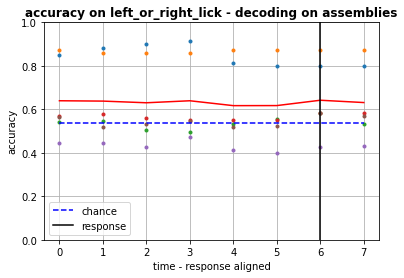

In [19]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):
    
    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
    
    # MP distribution
    patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)
    
    actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
    patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

    # split traces data by trial
    # [n_trials, n_assemblies, n_timepoints]
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = assemblyAct.T[lower_bound:upper_bound]

    # number of assemblies
    n_assemblies = assemblyAct.T.shape[1]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1 # where enough timepoints
    n_trials = np.sum(selected_trials) # number of trials
    X_response = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X[i].shape[0]-resp_timepoint>n_after_resp: # if not enough timepoints after response
                X_response[j,:,:] = x
                j +=1
                
    # transpose to have X in shape [n_trials, n_assemblies, n_timepoints]
    X_response = X_response.transpose(0,2,1)

    # analysis lick left or right, aligned at response
    decode_str = 'left_or_right_lick'
    b = trials_is_right_lick[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)
    
    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # decode from all correlations
        xt = X_response[:,:,t]

        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
         
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.')

# plot accuracy & chance level
plt.plot(x, y1,'r') # mean accuracy
plt.plot(x, y2, '--b', label="chance") # mean chance level

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response") # response timepoint
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [20]:
# saving as pickle file
output_filename = "assemblies_activity/lick_airpuff_assemblies.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(all_units_accuracy_diag_sessions, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis reward/punishment BEFORE response across sessions

all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4745762711864407
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.5285714285714286
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.6194690265486725
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.6610169491525424
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.8
all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.8846153846153846


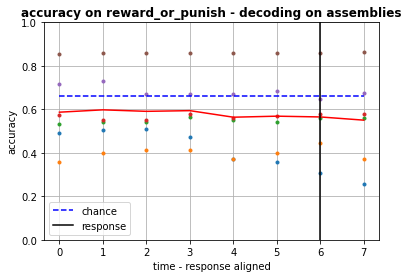

In [21]:
# set threshold for minimum time points before response
thr = 0.6
n_before_resp = 6
n_after_resp = 2
n_timepoints = n_before_resp+ n_after_resp

# initiate empty lists
all_units_accuracy_diag_sessions = []
overall_class_balance_sessions = []

# for each airpuff session:
for session in range(14,20):
    
    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]
    
    # MP distribution
    actmat = np.transpose(channels_array) # [n_cells, n_timepoints]
    patterns,significance,zactmat = assembly.runPatterns(actmat,nullhyp='mp')
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

    # split traces data by trial
    # [n_trials, n_assemblies, n_timepoints]
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = assemblyAct.T[lower_bound:upper_bound]

    # number of assemblies
    n_assemblies = assemblyAct.T.shape[1]
        
    #### DECODING ####
    selected_trials = ((trials_response[0:-1] - new_start[0:-1])>thr) * 1 # where enough timepoints
    n_trials = np.sum(selected_trials) # number of trials
    X_response = np.zeros(shape=(n_trials, n_timepoints , n_assemblies))
    j=0
    for i in range(len(new_start)-1):
        if selected_trials[i]==1:
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp,:]
            if X[i].shape[0]-resp_timepoint>n_after_resp: # if not enough timepoints after response
                X_response[j,:,:] = x
                j +=1
                
    # transpose to have X in shape [n_trials, n_assemblies, n_timepoints]
    X_response = X_response.transpose(0,2,1)
 
    # analysis on reward and punishment, aligned at response
    decode_str = 'reward_or_punish'
    b = trials_is_reward[0:-1]
    y = b[selected_trials==1]

    # ANALYSIS ALL 
    print("all units decoding - response aligned - %s" %decode_str)

    overall_class_balance = np.mean(y)
    overall_class_balance_sessions.append(overall_class_balance)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)
    
    # use only last kernel
    n_splits=3
    all_units_accuracy_diag = np.zeros(shape=(n_timepoints, n_splits))


    for t in range(n_timepoints):
        # decode from all correlations
        xt = X_response[:,:,t]


        #stratified kfold to ensure every split has balanced amount of class
        outer_skf = StratifiedKFold(n_splits=n_splits)
        s=0
        for train_index, test_index in outer_skf.split(xt,y):
            x_train, x_test = xt[train_index], xt[test_index]
            y_train, y_test = y[train_index], y[test_index]  

            #should be a grid search for tuning the parameter
            model = RidgeClassifierCV(alphas=[0.01, 0.1, 1])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            all_units_accuracy_diag[t,s] = accuracy_score(y_test,y_pred)
            s +=1
    all_units_accuracy_diag_sessions.append(np.mean(all_units_accuracy_diag, axis=1))
         
# plot reward or punishment at response (across sessions)
fig = plt.figure()

x = np.arange(n_timepoints)
y1 = np.mean(all_units_accuracy_diag_sessions, axis=0)
y2 = np.ones(shape=(n_timepoints,))*np.mean(overall_class_balance_sessions)
error_acc = np.std(np.mean(all_units_accuracy_diag_sessions,axis=0))
error_class = np.std(overall_class_balance_sessions)

# scatter plot of points from each session
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, i,'.')

# plot accuracy & chance level
plt.plot(x, y1,'r') # mean accuracy
plt.plot(x, y2, '--b', label="chance") # mean chance level

# shade: standard deviation of accuracy & chance level
#plt.fill_between(x, y1-error_acc, y1+error_acc,alpha=0.3,edgecolor='#CC4F1B', facecolor='#FF9848')
#plt.fill_between(x, y2-error_class, y2+error_class,alpha=0.3,edgecolor='#1B2ACC', facecolor='#089FFF')

plt.axvline(x=n_before_resp, color='k', label="response") # response timepoint
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('accuracy')
title_str = "accuracy on %s - decoding on assemblies"%decode_str       
plt.title(title_str, fontweight='bold')
plt.show()

In [22]:
# saving cell assemblies as pickle file
output_filename = "assemblies_activity/before_response_airpuff_assemblies.pkl"
with open(os.path.join(animal_folder_name,output_filename), 'wb') as fp:
    pickle.dump(all_units_accuracy_diag_sessions, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Difference in accuracy decoding on cell activity vs assemblies

In [23]:
n_before_resp = 6
n_after_resp = 2
# response: 5/15, stimulus: 24/5, before_response & lick: 6/2

In [24]:
# load pickle files
input_filename = "assemblies_activity/lick_airpuff_assemblies.pkl" # cell assemblies
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     all_units_accuracy_diag_sessions = pickle.load(fp)
        
input_filename = "assemblies_activity/lick_airpuff_activity.pkl" # cell activities
with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
     y1_activity = pickle.load(fp)

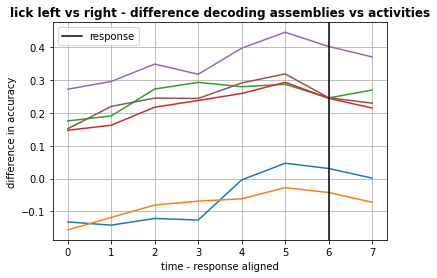

In [25]:
n_timepoints = len(all_units_accuracy_diag_sessions[0])
x = np.arange(n_timepoints)

# plot accuracy & chance level
for i in all_units_accuracy_diag_sessions:
    plt.plot(x, y1_activity-i,) # subtract each cell assembly accuracy from average cell activity accuracy

plt.axvline(x=n_before_resp, color='k', label="response") # response timepoint
#plt.ylim([0,1])
plt.grid()
plt.legend()
plt.xlabel('time - response aligned')
plt.ylabel('difference in accuracy')
#title_str = "reward_or_punish - difference decoding assemblies vs activities"
title_str = "lick left vs right - difference decoding assemblies vs activities"
#title_str = "stimulus left vs right - difference decoding assemblies vs activities"
plt.title(title_str, fontweight='bold')
plt.show()